In [1]:
!pip install indic-transliteration
!pip install --upgrade indic-transliteration
import os

# Disable wandb logging
os.environ['WANDB_MODE'] = 'disabled'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 4.8 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools



try:
    from indic_transliteration import sanscript
    from indic_transliteration.sanscript import transliterate
except ImportError:
    raise ImportError("Please install 'indic-transliteration' via `pip install indic-transliteration`")

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset, ClassLabel


TRAIN_FLAG = True  
BEST_MODEL_DIR = "./best_model"
MODEL_NAME = "bert-base-multilingual-cased"

2025-04-15 14:49:27.730967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744728567.912027      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744728567.964446      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

def convert_hinglish_to_hindi(text):
    
    def count_devanagari_ratio(text):
        
        if not text:
            return 1.0
        count = sum(1 for ch in text if '\u0900' <= ch <= '\u097F')
        return count / len(text)
    
    def transliterate_to_hindi(text):
        
        return transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI)

    if not text:
        return text
        
    if count_devanagari_ratio(text) < 0.3:
        return transliterate_to_hindi(text)
    return text

file_paths = {
    'en': {
        'train': '/kaggle/input/gender-abuse-train/train_en_l1.csv',
        'test': '/kaggle/input/gender-abuse-test/test_en_l1.csv'
    },
    'hi': {
        'train': '/kaggle/input/gender-abuse-train/train_hi_l1.csv',
        'test': '/kaggle/input/gender-abuse-test/test_hi_l1.csv'
    },
    'ta': {
        'train': '/kaggle/input/gender-abuse-train/train_ta_l1.csv',
        'test': '/kaggle/input/gender-abuse-test/test_ta_l1.csv'
    }
}


def aggregate_labels(df, lang):
    
    def get_expected_columns(lang):
        
        if lang == 'en':
            return [f"en_a{i}" for i in range(1, 7)]
        elif lang == 'hi':
            return [f"hi_a{i}" for i in range(1, 6)]
        elif lang == 'ta':
            return [f"ta_a{i}" for i in range(1, 7)]
        else:
            raise ValueError("Unknown language specified.")

    def calculate_majority_vote(df, columns):
        
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')
        df['avg_annotation'] = df[columns].mean(axis=1)
        df['label'] = (df['avg_annotation'] >= 0.5).astype(int)
        return df

    expected = get_expected_columns(lang)
    annotator_cols = [col for col in expected if col in df.columns]
    if not annotator_cols:
        raise ValueError(f"No annotator columns found for language '{lang}'. Expected columns: {expected}")
    
    return calculate_majority_vote(df, annotator_cols)

def check_required_columns(df, required_cols):
    
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")


def prepare_training_data():
    def process_language_data(lang, file_path):
        
        df_lang = pd.read_csv(file_path, engine='python')
        check_required_columns(df_lang, ['key', 'text'])
        df_lang = df_lang[df_lang['key'] == "question_1"]
        
        if lang == 'hi':
            df_lang['text'] = df_lang['text'].apply(convert_hinglish_to_hindi)
        
        df_lang = aggregate_labels(df_lang, lang)
        return df_lang[['text', 'label']]
    
    def combine_language_data():
        """Process and combine data from all languages."""
        train_dfs = [
            process_language_data(lang, paths['train'])
            for lang, paths in file_paths.items()
        ]
        return pd.concat(train_dfs, ignore_index=True)
    
    train_df = combine_language_data()
    print("Combined training samples:", len(train_df))
    return train_df


In [4]:

def train_model():
    def prepare_data():
        
        train_df = prepare_training_data()
        hf_dataset = Dataset.from_pandas(train_df)
        hf_dataset = hf_dataset.cast_column("label", ClassLabel(names=["0", "1"]))
        
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        def tokenize_function(example):
            return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
        
        tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
        tokenized_dataset = tokenized_dataset.remove_columns(["text"])
        tokenized_dataset.set_format("torch")
        
        split_data = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column="label")
        return split_data['train'], split_data['test'], tokenizer

    def setup_model_and_trainer(train_dataset, val_dataset, tokenizer):
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            return {"macro_f1": f1_score(labels, predictions, average="macro")}
        
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=10,
            weight_decay=0.01,
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            greater_is_better=True
        )
        
        return Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )

    def execute_training(trainer):
        print("Starting training ...")
        trainer.train()
        print("Training complete.")
        trainer.save_model(BEST_MODEL_DIR)
        trainer.tokenizer.save_pretrained(BEST_MODEL_DIR)
        print(f"Best model saved to: {BEST_MODEL_DIR}")
        return trainer.state.log_history

    # Execute the pipeline
    train_dataset, val_dataset, tokenizer = prepare_data()
    print(f"Training samples: {len(train_dataset)}\nValidation samples: {len(val_dataset)}")
    trainer = setup_model_and_trainer(train_dataset, val_dataset, tokenizer)
    return execute_training(trainer)

def plot_training_metrics(log_history):
    def plot_loss(entries, label, filename):
        epochs = []
        losses = []
        for entry in entries:
            ep = round(entry['epoch'], 2)
            loss_val = entry['eval_loss'] if 'eval_loss' in entry else entry['loss']
            epochs.append(ep)
            losses.append(loss_val)

        plt.figure()
        plt.plot(epochs, losses, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel(f'{label} Loss')
        plt.title(f'{label} Loss per Epoch')
        plt.savefig(filename)
        plt.show()

    def filter_entries(is_validation):
        if is_validation:
            return sorted(
                [e for e in log_history if 'eval_loss' in e and 'epoch' in e],
                key=lambda x: x['epoch']
            )
        return [e for e in log_history if 'loss' in e and 'epoch' in e and 'eval_loss' not in e]

    
    plot_loss(filter_entries(False), 'Training', 'training_loss.png')
    plot_loss(filter_entries(True), 'Validation', 'validation_loss.png')

def train_and_save_model():
    log_history = train_model()
    plot_training_metrics(log_history)


def load_and_prepare_test_eval(file_path, lang, tokenizer):
    
    def process_dataframe():
        df = pd.read_csv(file_path, engine='python')
        check_required_columns(df, ['key', 'text'])
        df = df[df['key'] == "question_1"]
        
        if lang == 'hi':
            df['text'] = df['text'].apply(convert_hinglish_to_hindi)
        
        return aggregate_labels(df, lang)
    
    def prepare_dataset(df):
        tmp_dataset = Dataset.from_pandas(df[['text']])
        
        def tokenize_function(example):
            return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
        
        tmp_dataset = tmp_dataset.map(tokenize_function, batched=True)
        tmp_dataset = tmp_dataset.remove_columns(["text"])
        tmp_dataset.set_format("torch")
        return tmp_dataset
    
    df = process_dataframe()
    dataset = prepare_dataset(df)
    return df, dataset

def infer_sentence(sentence, model, tokenizer):
    def prepare_inputs(text):
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        inputs = tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            padding="max_length", 
            max_length=128
        )
        return {k: v.to(device) for k, v in inputs.items()}, device
    
    def get_prediction(model_inputs):
        model.eval()
        with torch.no_grad():
            outputs = model(**model_inputs)
        logits = outputs.logits.detach().cpu().numpy()
        pred = np.argmax(logits, axis=-1)[0]
        return "Gendered abuse" if pred == 1 else "Not gendered abuse"
    
    inputs, _ = prepare_inputs(sentence)
    return get_prediction(inputs)


def evaluate_test_sets():
    
    def setup_model_and_trainer():
        
        loaded_model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_DIR)
        loaded_tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_DIR)
        return loaded_model, loaded_tokenizer, Trainer(
            model=loaded_model,
            args=TrainingArguments(output_dir="./eval_results"),
            tokenizer=loaded_tokenizer
        )

    def get_predictions_and_metrics(df_test, test_dataset, eval_trainer):
        
        predictions = eval_trainer.predict(test_dataset)
        pred_labels = np.argmax(predictions.predictions, axis=-1)
        df_test["predicted_label"] = pred_labels
        macro_f1 = f1_score(df_test["label"], df_test["predicted_label"], average="macro")
        return df_test, macro_f1, confusion_matrix(df_test["label"], df_test["predicted_label"])

    def plot_and_save_results(df_test, macro_f1, cm, lang):
        
        
        output_csv = f"predictions_test_{lang}_l1.csv"
        df_test.to_csv(output_csv, index=False)
        print(f"Saved predictions to: {output_csv}")
        print(f"Macro-F1 for {lang.upper()} test set: {macro_f1}")

        
        plt.figure(figsize=(6,6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {lang.upper()} Test Set')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ["Not gendered abuse", "Gendered abuse"], rotation=45)
        plt.yticks(tick_marks, ["Not gendered abuse", "Gendered abuse"])
        thresh = cm.max() / 2.0
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        cm_filename = f'confusion_matrix_{lang}_l1.png'
        plt.savefig(cm_filename)
        plt.show()
        print(f"Saved confusion matrix to: {cm_filename}")

    
    loaded_model, loaded_tokenizer, eval_trainer = setup_model_and_trainer()
    
    for lang, paths in file_paths.items():
        print(f"\n=== Evaluating {lang.upper()} Test Set ===")
        df_test, test_dataset = load_and_prepare_test_eval(paths['test'], lang, loaded_tokenizer)
        df_test, macro_f1, cm = get_predictions_and_metrics(df_test, test_dataset, eval_trainer)
        plot_and_save_results(df_test, macro_f1, cm, lang)

def run_inference_on_test():
    
    evaluate_test_sets()
    
    
    loaded_model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_DIR)
    loaded_tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_DIR)
    
    
    example_text = "You should be ashamed of yourself!"
    label_inference = infer_sentence(example_text, loaded_model, loaded_tokenizer)
    print("\nSingle-Sentence Inference Example:")
    print("Text:", example_text)
    print("Prediction:", label_inference)


Combined training samples: 19507


Casting the dataset:   0%|          | 0/19507 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/19507 [00:00<?, ? examples/s]

Training samples: 15605
Validation samples: 3902


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/4023600025.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training ...


Epoch,Training Loss,Validation Loss,Macro F1
1,0.536100,0.483413,0.705983
2,0.450000,0.469249,0.744494
3,0.371400,0.545652,0.745106
4,0.281900,0.619810,0.742655
5,0.227000,0.795885,0.735350
6,0.180900,0.888282,0.734570
7,0.163200,1.156305,0.730242
8,0.128600,1.261287,0.725872
9,0.097200,1.322071,0.725508
10,0.081800,1.478428,0.714973


Training complete.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Best model saved to: ./best_model


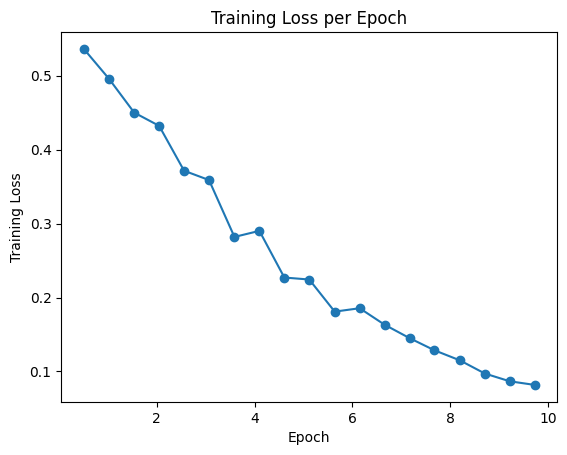

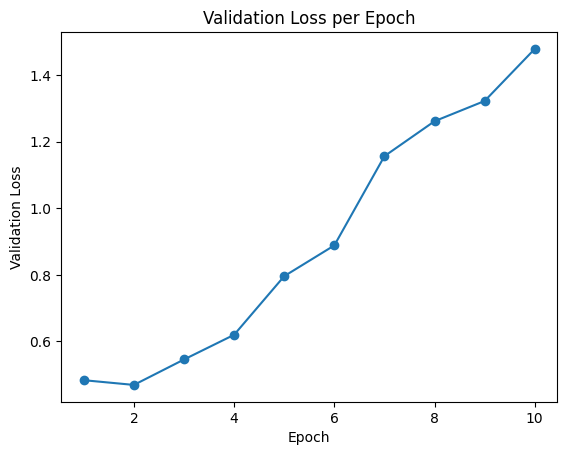

/tmp/ipykernel_19/4023600025.py:160: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return loaded_model, loaded_tokenizer, Trainer(



=== Evaluating EN Test Set ===


Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

Saved predictions to: predictions_test_en_l1.csv
Macro-F1 for EN test set: 0.7145330631792226


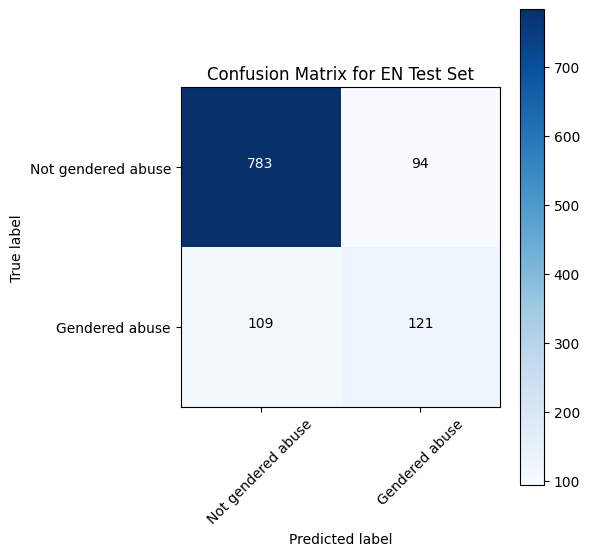

Saved confusion matrix to: confusion_matrix_en_l1.png

=== Evaluating HI Test Set ===


Map:   0%|          | 0/1516 [00:00<?, ? examples/s]

Saved predictions to: predictions_test_hi_l1.csv
Macro-F1 for HI test set: 0.69364237912625


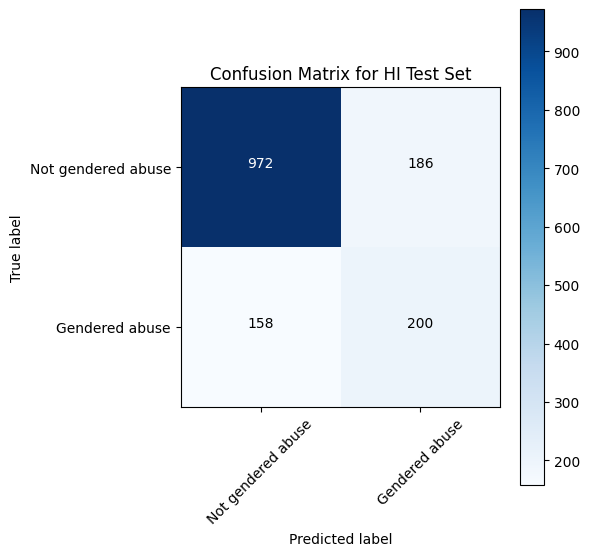

Saved confusion matrix to: confusion_matrix_hi_l1.png

=== Evaluating TA Test Set ===


Map:   0%|          | 0/1135 [00:00<?, ? examples/s]

Saved predictions to: predictions_test_ta_l1.csv
Macro-F1 for TA test set: 0.816620371233447


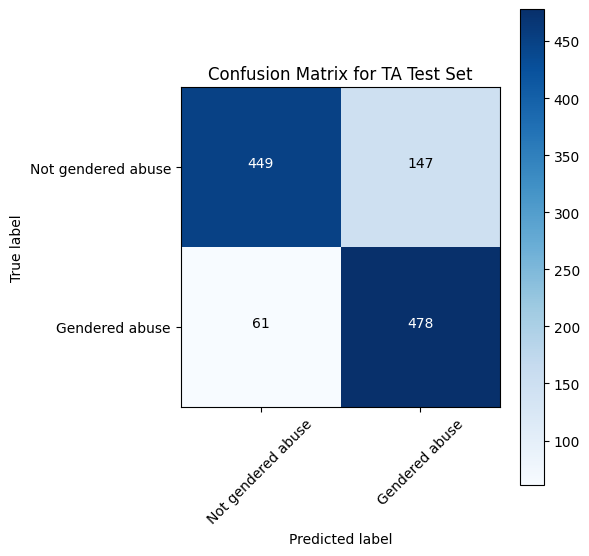

Saved confusion matrix to: confusion_matrix_ta_l1.png

Single-Sentence Inference Example:
Text: You should be ashamed of yourself!
Prediction: Not gendered abuse


In [5]:

def main():
    if TRAIN_FLAG:
        
        train_and_save_model()
        
        run_inference_on_test()
    else:
        
        run_inference_on_test()

if __name__ == "__main__":
    main()  

In [6]:
import shutil
from IPython.display import FileLink


folder_to_zip = "/kaggle/working/best_model"
output_filename = "best_model_zip"


shutil.make_archive(output_filename, 'zip', folder_to_zip)


print("Zipped folder saved as: " + output_filename + ".zip")
FileLink(f"{output_filename}.zip")

Zipped folder saved as: best_model_zip.zip


/kaggle/working/best_model_zip.zip